## Разработка и обучение свёрточной нейронной сети (CNN) для классификации изображений

### Задачи

1. Разработайте архитектуру свёрточной нейронной сети для задачи классификации изображений.
Опишите ваши соображения при выборе слоев (тип, количество, последовательность) и гиперпараметров (размер фильтров, их количества, функции активации и другие).
2. Подготовьте все необходимые элементы для процесса обучения из инструментария pytorch:
загрузчики данных, необходимую функцию потерь. Загрузить данные для обучения (предобработка данных: перевод в тензорный вид, при необходимости — изменеие размеров изображений — resize).
3. Обучите модель на подготовленном наборе данных.
4. Оцените качество обучения модели на тестовой выборке
(по функции потерь — validation loss и точности — accuracy).
5. Реализуйте один (на выбор) из следующих метод борьбы с переобучением:
* cлой Dropout (если не было в разработанной архитектуре)
* cлой BatchNorm (если не было в разработанной архитектуре)
* регуляризация функции потерь,
* техники data augmentation
(дополнение данных — модификация копий изображений в обучающей выборке)
6. Подготовьте краткий отчет
(в свободной форме) с описанием выполненных шагов, архитектуры модели, процесса обучения, полученных результатов. Сделайте краткие выводы. Приложите к отчету визуализации (графики метрик обучения — loss, accuracy, примеры предсказаний сети).

## 1. Разработка архитектуры свёрточной нейронной сети для задачи классификации изображений

### 1.1 Для начала работы необходимо импортировать требуемые библиотеки:

In [74]:
import matplotlib.pyplot as plt
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch.nn as nn
import torch.optim as O
import torch.nn.functional as F
from torch.utils.data import DataLoader as DL
from torchvision.utils import make_grid

from torchvision import datasets
from torchvision import transforms as T

### 1.2 Разработка архитектуры свёрточной нейронной сети для задачи классификации изображений

В качестве обучающей библиотеки принимаем набор CIFAR10.

Создаем архитектуру нейросети по типу LeNet. Она будет состоять из 9 слоев:
* __"тело" нейросети (производим перобразование 2-хмерного тнезора):__
1. Сверточный слой 1: преобразует входящий тензор размиером 32х32 с 3 каналами (3 цвета входного изображения) в тензор 30х30, но оставляющий тот же размер (с 8 каналами) за счет параметра padding=1 (используем для более корректной работы нейросети после обработки тензора следующим слоем). Размер ядра свертки 3х3, шаг=1.
2. Слой пулинга 1: преобразует тензор 32х32 в тензор 16х16 (использется MaxPooling). Размер ядра пулинга - 2х2, шаг=2.
3. Сверточный слой 2: преобразует входящий тензор размиером 16х16 с 8 каналами в тензор 15х15, но оставляющий тот же размер с 16 каналами за счет параметра padding=1 (используем для более корректной работы нейросети после обработки тензора следующим слоем). Размер ядра свертки 3х3, шаг=1.
4. Слой пулинга 2: преобразует тензор 16х16 в тензор 8х8 (использется MaxPooling). Размер ядра пулинга - 2х2, шаг=2.
5. Сверточный слой 3: преобразует входящий тензор размиером 8х8 с 16 каналами в тензор 6х6 с 32 каналами. Размер ядра свертки 3х3, шаг=1.
6. Слой пулинга 2: преобразует тензор 6х6 с 16 каналами в тензор 3х3 с 32 каналами (использется MaxPooling). Размер ядра пулинга - 2х2, шаг=2.
* на выходе "тела" нейросети получаем тензор 3х3 с 32 каналами.
* в "теле" нейросети используем функцию активации SiLU (Swish), которая показала себя лучше, чем ReLU при исптыниях сети
* также во всех сверточных слоях используем нормализацию батчей, необходимую для устранения переобучения, возникшего на начальных этапах (см. задание 5)
* __"голова" нейросети (производим преобразование одномерного тензора):__
1. Полносвязный слой 1: преобразует тензор 3х3 с 32 каналами в линейный тензор весов размером 128
2. Полносвязный слой 2: преобразует линейный тензор размером 128 в тензор весов размером 64
3. Полносвязный слой 3: преобразует линейный тензор размером 64 в тензор весов размером 10 (по количеству классов набора CIFAR10)
* в "голове" нейросети используем функцию активацию LeakyReLU? которая также показала себя лучше, чем ReLU при исптыниях сети за счет решения проблемы "мертвых нейронов" в ReLU.

In [75]:
# Архитектура нейросети
class CNN(nn.Module):
    def __init__(self):
        super().__init__() # наследование метода суперкласса (родительского класса)
        # Sequential слой - контейнер для цепи преобразующих слоев
        
        # backbone (body)
        self._body = nn.Sequential(
            # Сверточный слой 1: вход = (32, 32), выход = (32, 32)
            nn.Conv2d(in_channels=3, out_channels=8, padding=1, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.SiLU(inplace=True),
            # Слой пулинга 1: вход = (32, 32), выход = (16, 16)
            nn.MaxPool2d(kernel_size=2, stride=2),
              
            # Сверточный слой 2: вход = (16, 16), выход = (16, 16)
            nn.Conv2d(in_channels=8, out_channels=16, padding=1, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.SiLU(inplace=True),
            # Слой пулинга 2: вход = (16, 16), выход = (8, 8)
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Сверточный слой 3: вход = (8, 8), выход = (6, 6)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.SiLU(inplace=True),
            # Слой пулинга 2: вход = (6, 6), выход = (3, 3)
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # head
        self._head = nn.Sequential(
            # Полносвязный слой 1 32*3*3 -> 128
            nn.Linear(in_features=32*3*3, out_features=128), 
            nn.LeakyReLU(inplace=True),
            
            # Полносвязный слой 2 32*3*3 -> 64
            nn.Linear(in_features=128, out_features=64), 
            nn.LeakyReLU(inplace=True),
            
            # Полносвязный слой 3 32*3*3 -> 10 (классы CIFAR10)
            nn.Linear(in_features=64, out_features=10)
        )
        
    # функция реализации последовательности слоев    
    def forward(self, x):
        x = self._body(x)
        x = x.view(x.size()[0], -1)
        x = self._head(x)
        return x

### 1.3 Размеры свертки для более точного пректирования нейросети рассчитывались с помощью функции ниже:

In [76]:
def conv_calc(data, k, p, d, s):
    
    '''
    data - размерность входного тензора
    k - размер ядра [int, int]
    p - паддинг [int, int]
    d - расширение [int, int] (используются значения по умолчанию в torch - (1, 1))
    s - шаг ядра [int, int] (используются значения по умолчанию в torch - (1, 1))
    '''
    
    h_out = ((data[1] + 2 * p - d[0] * (k[0] - 1) - 1) / s[0]) + 1
    w_out = ((data[2] + 2 * p - d[1] * (k[1] - 1) - 1) / s[1]) + 1
    
    return (int(h_out), int(w_out))

In [77]:
in_dim = (3, 32, 32) # размерность входного тензора
in_dim

(3, 32, 32)

In [78]:
# пример использования функции
c_out = 8# количество каналов на выходе
k = (3,3)
p = 0
d = (1,1) # pytorch default
s = (1,1) # pytorch default

out = conv_calc(in_dim, k, p, d, s)
c_out, out

(8, (30, 30))

## 2. Подготовка всех необходимых элементов для процесса обучения из инструментария pytorch

### 2.1 Вначале создаем специальные классы, в которых задаем системные и обучающие праметры нейросети:

In [79]:
# Системные параметры
@dataclass
class SystemConfiguration:
    seed: int = 42  # задаем зерно

Зерно - константа, выносится в системные параметры в целях гарантии ее неизменности в процессе обучения

In [80]:
# Обучающие параметры
@dataclass
class TrainingConfiguration:
    batch_size: int = 32  # размер обучающей выборки
    epochs_count: int = 10  # количество эпох обучения
    learning_rate: float = 0.01  # скорость обучения
    log_interval: int = 100  # интервал для вывода результата обучения в логи для обучающей выборки
    test_interval: int = 1  # интервал для вывода результата тестовой выборки (количество эпох) 
    data_root: str = "data"  # каталог для загрузки набора данных
    num_workers: int = 8  # количество потоков для обучения нейросети

### 2.2 Предобработка данных

**Нормализация данных**

Создаем функцию вычисления среднего и станадртного отклонения для 3-канального изображения. Она необходима при нормализации тензора во время создания выборки

In [81]:
def get_mean_std_train_data(data_root):
    train_set = datasets.CIFAR10(root=data_root, train=True, download=True)

    r_mean = train_set.data[...,0].mean()/255 # каналы в последнем измерении
    r_std = train_set.data[...,0].std()/255
    g_mean = train_set.data[...,1].mean()/255
    g_std = train_set.data[...,1].std()/255
    b_mean = train_set.data[...,2].mean()/255
    b_std = train_set.data[...,2].std()/255

    mean = (r_mean, g_mean, b_mean)
    std = (r_std, g_std, b_std)
    
    return mean, std

**Функция для загрузки и подготовки данных:**
* Набор трансформаций (использует pytorch-класс transforms):
1. изменяем размер всех загружаемых изображений (необязательно для набора CIFAR10);
2. преобразуем изображение в тензор;
2. переводим в тензорный вид и нормализуем по рассчитанных с помощью функции выше среднему значению и стандартному отклонению).
* train_loader - загрузчик обучающей выборки (использует общий pytorch-класс загрузчика torch.utils.data.DataLoader): определяется размер батча, обязательно перемешивание элементов, число потоков процессора для загрузки данных
* test_loader - загрузчик проверочной выборки (также использует общий pytorch-класс загрузчика): также размер батча, перемешивание отсутствует, число потоков процессора

In [82]:
def get_data(batch_size=TrainingConfiguration.batch_size,
             data_root=TrainingConfiguration.data_root,
             num_workers=TrainingConfiguration.num_workers):
    
    train_test_transforms = T.Compose([
        T.Resize((32, 32)), # Resize initial 28x28 size to 32X32
        T.ToTensor(), # re-scales image values [0-255] to tensor values [0-1]
        T.Normalize(*get_mean_std_train_data(data_root))  # subtract mean, divide by variance по функции выше
    ])
    
    # загрузчик обучающей выборки
    train_loader = DL(
        datasets.CIFAR10(root=data_root, train=True, download=True,
                         transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    # загрузчик проверочной выборки
    test_loader = DL(
        datasets.CIFAR10(root=data_root, train=False, download=True, transform=train_test_transforms),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    return train_loader, test_loader

### 2.3 Визуализация датасета
Производим промежуточную загрузку данных с целью их аудита (для набора CIFAR10 необязательно) по аналогии с создание обучающей выборки

In [83]:
trans = T.ToTensor()
visual_loader = DL(
    datasets.CIFAR10(root=TrainingConfiguration.data_root, train=True,
                     download=True, transform=trans),
        batch_size=TrainingConfiguration.batch_size,
        shuffle=True,
        num_workers=TrainingConfiguration.num_workers
    )

Files already downloaded and verified


__Функция визуализации данных__

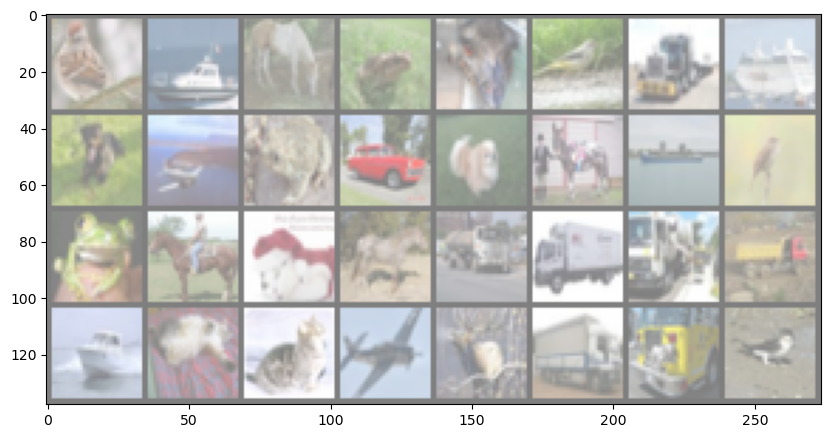

bird  ship  horse frog  bird  bird  truck ship  dog   airplane frog  automobile dog   horse ship  bird  frog  horse cat   horse truck truck truck truck ship  cat   cat   airplane deer  truck truck bird 


In [84]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def imshow(img):
    img = img / 2 + 0.5 # денормализуем выборку
    npimg = img.numpy() # перевод в массив numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # замена местами размерностей: C,H,W --> H,W,C (matplotlib ожидает такой порядок ввода) 
    plt.show()

dataiter = iter(visual_loader) # итератор на основе загрузчика
images, labels = next(dataiter) # вызваем следующий объект итератора

# Вывод изображений и меток
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(TrainingConfiguration.batch_size)))

## 3. Обучение модели на подготовленном наборе данных

### 3.1 Функция, определяющая ход обучения:
* комментарии по использованию приведены в коде

In [85]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: O.Optimizer,
    train_loader: DL, epoch_idx: int
):
    
    model.train() # модель в режиме обучения
    batch_loss = np.array([]) # массив для аккумуляции потерь батчей
    batch_acc = np.array([]) # массив для аккумуляции точности батчей

# начинаем итеративные проходы по выборкам
    for batch_idx, (data, target) in enumerate(train_loader):
        
        indx_target = target.clone() # клонируем выборку
 
        optimizer.zero_grad() # обнуляем градиент
        output = model(data) # загружаем данные в модель
        loss = F.cross_entropy(output, target) # в качестве функции потерь используем кросс-энтропию
        
        loss.backward() # корректируем градиент в обратном направлении
        optimizer.step() # с помощью функции-оптимизатора (для данной модели используем Adam) обновляем веса
        
        batch_loss = np.append(batch_loss, [loss.item()]) # добавляем общую потерю батча в ранее созданный массив
        
        prob = F.softmax(output, dim=1) # с помощью функции активации Softmax рассчитываем вероятности
        pred = prob.data.max(dim=1)[1]  # получаем индекс максимальной аероятности
                        
        correct = pred.cpu().eq(indx_target).sum() # рассчитываем количество верных предсказаний нейросети
        acc = float(correct) / float(len(data)) # расчет общей точности предсказания для батча
        batch_acc = np.append(batch_acc, [acc]) # добавляем общую точность для батча в ранее созданный массив

# вывод информации в логи
        if batch_idx % train_config.log_interval == 0 and batch_idx > 0:              
            print(
                'Train Epoch: {} [{}/{}] Loss: {:.6f} Acc: {:.4f}'.format(
                    epoch_idx, batch_idx * len(data), len(train_loader.dataset), loss.item(), acc
                )
            )
# расчет средней потери и аккуратности при обучении нейросети
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    return epoch_loss, epoch_acc

### 3.2 Функция, определяющая процедуру проверки
* комментарии по использованию приведены в коде

In [86]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: DL,
):

    model.eval() # модель в режиме тестирования
    test_loss = 0 # потери при тестирования батча
    count_corect_predictions = 0 # точность при тестировании батча
    
    with torch.no_grad(): # контекстный менеджер, запрещающий расчет градиента (нет необходимости при тестировании)
        # начинаем итеративные проходы по выборкам
        for data, target in test_loader:
            
            indx_target = target.clone() # клонируем выборку
            output = model(data) # загружаем данные в модель
            
            test_loss += F.cross_entropy(output, target).item() # суммируем потери для каждого батча
            prob = F.softmax(output, dim=1) # с помощью функции активации Softmax рассчитываем вероятности
            pred = prob.data.max(dim=1)[1] # получаем индекс максимальной аероятности
            count_corect_predictions += pred.cpu().eq(indx_target).sum() # рассчитываем количество верных предсказаний нейросети

        test_loss = test_loss / len(test_loader) # расчет средней потери для всех батчей
        accuracy = 100. * count_corect_predictions / len(test_loader.dataset) # средняя точность выборки

# вывод информации в логи
        print(
            '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
            )
        )
    return test_loss, accuracy/100.0

### 3.3 Функция основного цикла обучения
* комментарии по использованию приведены в коде

In [87]:
# Функция для загрузки системных параметров
def setup_system(system_config: SystemConfiguration):
    torch.manual_seed(system_config.seed)

In [88]:
# Функция обучения
def main(
    model, 
    system_configuration=SystemConfiguration(), 
    training_configuration=TrainingConfiguration()
):
    setup_system(system_configuration) # устанавливаем определенные ранее системные параметры

    # настройка обучающих параметров:
    batch_size_to_set = training_configuration.batch_size # размер батча
    num_workers_to_set = training_configuration.num_workers # количество потоков вычисления
    epoch_num_to_set = training_configuration.epochs_count # количество эпох

    # создаем загрузчики данных
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set
    )

    # задаем оптимизатор - тспользуем Adam,
    # т.к. по сравнению с градиентным спуском, он поддерживает единую скорость обучения
    # для всех обновлений весов, и скорость обучения не меняется
    optimizer = O.Adam(
        model.parameters(), # загружаем парамаетры модели
        lr=training_configuration.learning_rate # устанавливаем скорость обучения
    )

    best_loss = torch.tensor(np.inf) # для поиска лучшей потери (минимальной) задаем начальное значение равное бесконечности
    
    # массивы для фиксации потерь и точности обучающей и тестовой выборки
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
   
    t_begin = time.time()  # время начала обучения
   
    # начинаем итеративное обучение модели     
    for epoch in range(training_configuration.epochs_count):
        
    # расчет потерь и точности для обучающей выборки
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])
        
    # время начала обучения эпохи
        elapsed_time = time.time() - t_begin
    # скорость обучения эпохи
        speed_epoch = elapsed_time / (epoch + 1)
    # скорость обучения батча
        speed_batch = speed_epoch / len(train_loader)
    # время обучения эпохи
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
    # вывод логов эпохи
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

    # расчет и вывод данных для определенного ранее шага батчей
        if epoch % training_configuration.test_interval == 0:
            
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
    # вывод общей информации об обучении 
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

### 3.4 Запуск обучения нейросети

In [89]:
model = CNN()
model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc = main(model)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 0 [3200/50000] Loss: 1.717293 Acc: 0.3750
Train Epoch: 0 [6400/50000] Loss: 1.686604 Acc: 0.4375
Train Epoch: 0 [9600/50000] Loss: 1.465925 Acc: 0.5312
Train Epoch: 0 [12800/50000] Loss: 1.782255 Acc: 0.3125
Train Epoch: 0 [16000/50000] Loss: 1.389386 Acc: 0.4375
Train Epoch: 0 [19200/50000] Loss: 1.228085 Acc: 0.6250
Train Epoch: 0 [22400/50000] Loss: 1.237424 Acc: 0.4688
Train Epoch: 0 [25600/50000] Loss: 1.257074 Acc: 0.5938
Train Epoch: 0 [28800/50000] Loss: 1.596311 Acc: 0.4375
Train Epoch: 0 [32000/50000] Loss: 1.379762 Acc: 0.6250
Train Epoch: 0 [35200/50000] Loss: 1.494650 Acc: 0.4375
Train Epoch: 0 [38400/50000] Loss: 1.137573 Acc: 0.5625
Train Epoch: 0 [41600/50000] Loss: 1.262402 Acc: 0.5938
Train Epoch: 0 [44800/50000] Loss: 1.529266 Acc: 0.4062
Train Epoch: 0 [48000/50000] Loss: 0.994013 Acc: 0.6562
Elapsed 33.84s, 33.84 s/epoch, 0.02 s/batch, ets 

Train Epoch: 8 [28800/50000] Loss: 0.732372 Acc: 0.7188
Train Epoch: 8 [32000/50000] Loss: 0.842177 Acc: 0.7188
Train Epoch: 8 [35200/50000] Loss: 0.638673 Acc: 0.8438
Train Epoch: 8 [38400/50000] Loss: 0.895834 Acc: 0.6250
Train Epoch: 8 [41600/50000] Loss: 0.740312 Acc: 0.7812
Train Epoch: 8 [44800/50000] Loss: 1.219289 Acc: 0.5312
Train Epoch: 8 [48000/50000] Loss: 0.899464 Acc: 0.7812
Elapsed 394.29s, 43.81 s/epoch, 0.03 s/batch, ets 43.81s

Test set: Average loss: 0.8998, Accuracy: 6907/10000 (69%)

Train Epoch: 9 [3200/50000] Loss: 0.708737 Acc: 0.7500
Train Epoch: 9 [6400/50000] Loss: 0.561134 Acc: 0.7500
Train Epoch: 9 [9600/50000] Loss: 0.828682 Acc: 0.6562
Train Epoch: 9 [12800/50000] Loss: 0.590645 Acc: 0.8125
Train Epoch: 9 [16000/50000] Loss: 0.788427 Acc: 0.6250
Train Epoch: 9 [19200/50000] Loss: 0.936786 Acc: 0.7500
Train Epoch: 9 [22400/50000] Loss: 0.746870 Acc: 0.7188
Train Epoch: 9 [25600/50000] Loss: 0.730811 Acc: 0.7812
Train Epoch: 9 [28800/50000] Loss: 0.754554 A

## 4. Оценка качества обучения модели на тестовой выборке
* Как видно выше точность обучения составляет 71%, при этом лучшие потери - 0,891.
* Общее время обучения - 450 сек.
* Даная модель, в соответствии с заданием реализована без доступа к ускорителю GPU.
Сократить время обучения можно при подключении видеокарты.
* Результаты точности и потерь по эпохам выведены на графики ниже

Text(0.5, 1.0, 'Training and Validation Accuracy')

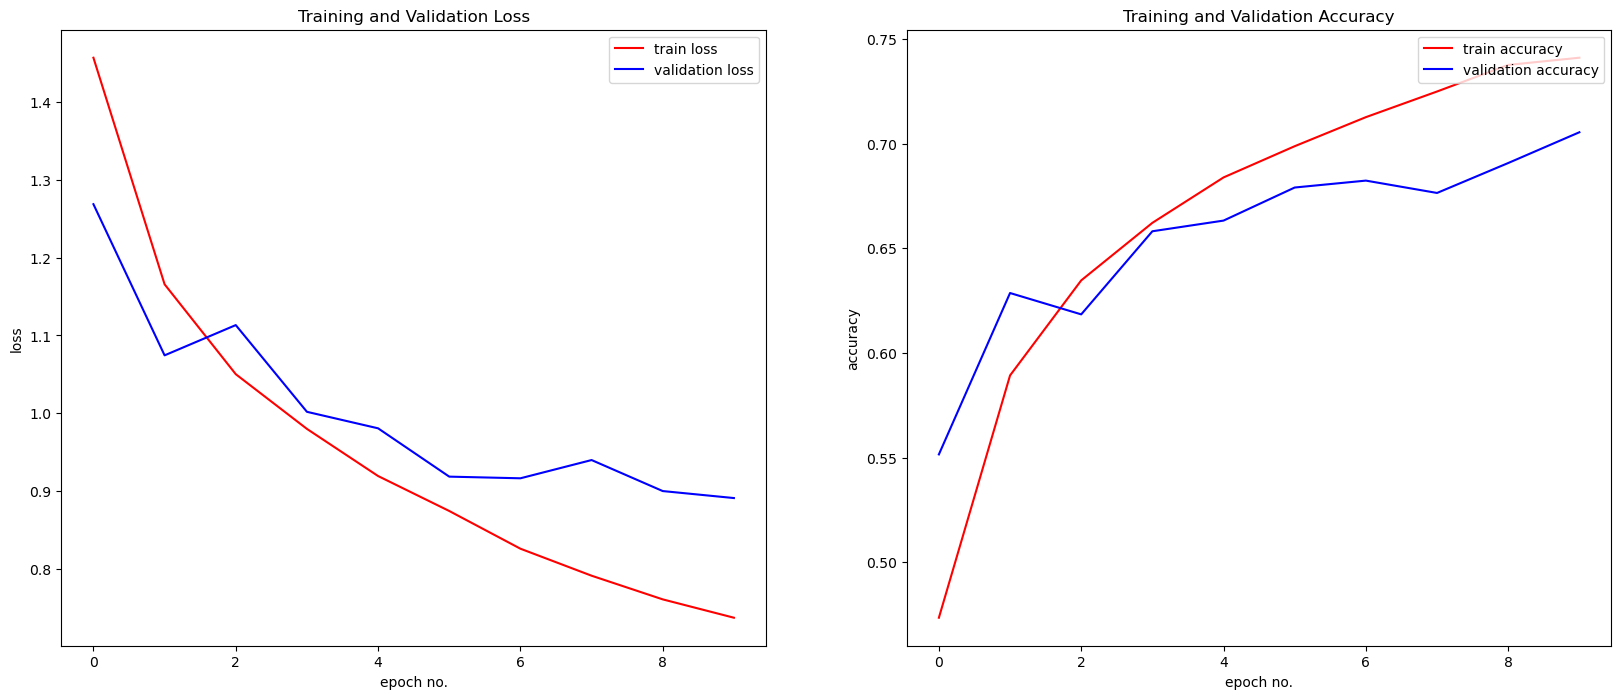

In [91]:
# Plot loss
plt.rcParams["figure.figsize"] = (10, 6)
x_loss = range(len(epoch_train_loss))
x_acc = range(len(epoch_train_acc))

plt.figure(figsize=[20,8])
plt.subplot(121)
plt.plot(x_loss, epoch_train_loss, 'r', label="train loss")
plt.plot(x_loss, epoch_test_loss, 'b', label="validation loss")
plt.xlabel('epoch no.')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(122)
plt.plot(x_acc, epoch_train_acc, 'r', label="train accuracy")
plt.plot(x_acc, epoch_test_acc, 'b', label="validation accuracy")
plt.xlabel('epoch no.')
plt.ylabel('accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')



## 5. Реализация борьбы с переобучением.
В качестве метода борьбы с переобучением модели использована нормализация BatchNorm.
Без ее использования и достаточно бльшим количеством эпох точность предсказаний тестовой выборки падала при растущей точности обучающей выборки, потери тестовой выборки, соответственно, росли при понижении потерь обучающей выборки.

## 6. Примененрие сети
Берем батч из загрузчика проверочной выборки, выбираем одно изображение (по индексам), пропускаем через сеть, смотрим результат, сравниваем с предсказанным

### 6.1 Выгрузка изображения из набора CIFAR10

In [92]:
check_pic_loader = DL(
    datasets.CIFAR10(root=TrainingConfiguration.data_root, train=True,
                     download=True, transform=trans),
        shuffle=True,
        num_workers=TrainingConfiguration.num_workers
    )

Files already downloaded and verified


### 6.2 Вывод тестового изображения

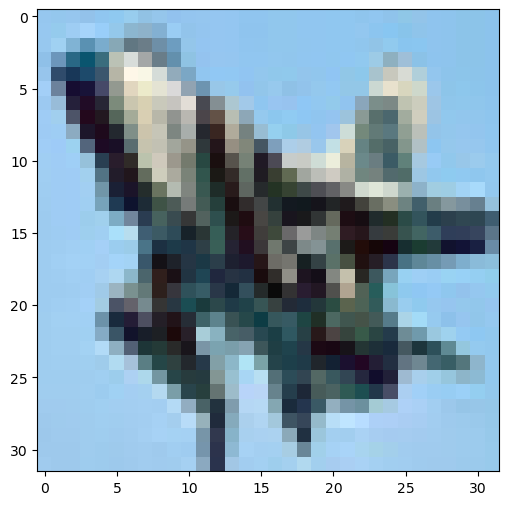

In [93]:
def imshow(img):
    npimg = img.numpy() # перевод в массив numpy
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # замена местами размерностей: C,H,W --> H,W,C (matplotlib ожидает именно так) 
    plt.show()

dataiter = iter(check_pic_loader) # итератор на основе загрузчика
image, label = next(dataiter) # метод next - вызвать следующий объект итератора

imshow(make_grid(image))

### 6.3 Генерируем предсказание сети

In [94]:
with torch.no_grad():
    outputs = model(image)
    print(outputs)
    _, pred = torch.max(outputs,dim=1)
    pred = pred.numpy()

tensor([[ 3.0916, -4.2743,  1.9207,  2.5177,  2.4539,  0.4588,  1.3590, -2.7155,
          2.4387, -0.7330]])


In [95]:
classes[pred[0]]

'airplane'

### 6.4 Метка изображения

In [96]:
classes[label]

'airplane'

## ВЫВОД: Предсказание соответствует реальности